Data for MG Road: {'flowSegmentData': {'frc': 'FRC2', 'currentSpeed': 20, 'freeFlowSpeed': 26, 'currentTravelTime': 1736, 'freeFlowTravelTime': 1335, 'confidence': 1, 'roadClosure': False, 'coordinates': {'coordinate': [{'latitude': 12.996265607778996, 'longitude': 77.66815242768922}, {'latitude': 12.996179770508848, 'longitude': 77.66810817124048}, {'latitude': 12.99615698401634, 'longitude': 77.66808939577732}, {'latitude': 12.996119414884342, 'longitude': 77.66803575159702}, {'latitude': 12.996065838025416, 'longitude': 77.66791773440036}, {'latitude': 12.996033659235673, 'longitude': 77.66783995033893}, {'latitude': 12.995965218039597, 'longitude': 77.66767365337995}, {'latitude': 12.995939736348397, 'longitude': 77.66761464478162}, {'latitude': 12.995920951766667, 'longitude': 77.66756904722831}, {'latitude': 12.995778842276314, 'longitude': 77.66724584104196}, {'latitude': 12.995569598154495, 'longitude': 77.66673085691099}, {'latitude': 12.995479758703793, 'longitude': 77.666522

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

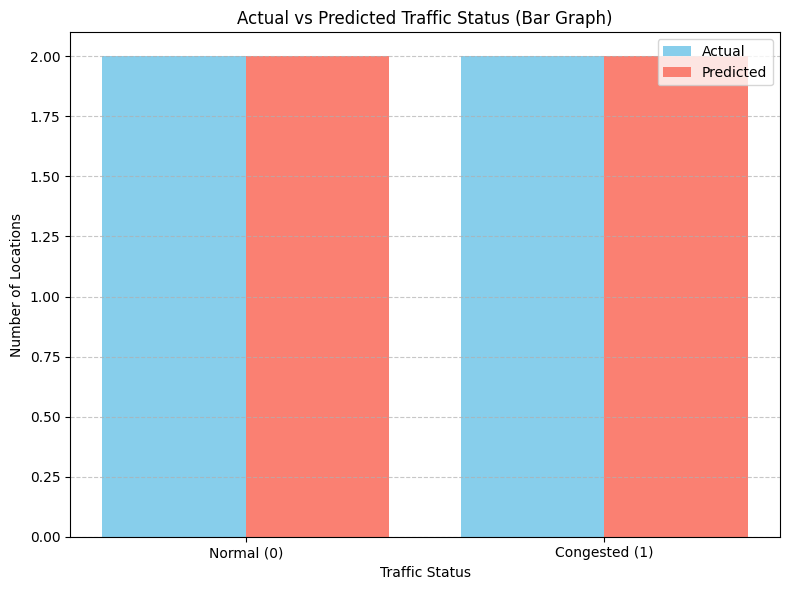

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ✅ Install necessary libraries
!pip install requests folium matplotlib pandas scikit-learn

# ✅ Import libraries
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

# ✅ TomTom API key (replace with your actual key)
TOMTOM_API_KEY = 'DJBbXUwoATdNYqXEupIyXILWDZ6ys0cp'

# ✅ Sample Bangalore locations with lat/lon
locations = {
    "MG Road": (12.975, 77.605),
    "Whitefield": (12.969, 77.749),
    "Electronic City": (12.839, 77.677),
    "Hebbal": (13.046, 77.591),
    "Yelahanka": (13.100, 77.596)
}

# ✅ Fetch live traffic data
data_list = []

for area, (lat, lon) in locations.items():
    url = f"https://api.tomtom.com/traffic/services/4/flowSegmentData/relative0/10/json?point={lat}%2C{lon}&key={TOMTOM_API_KEY}"
    response = requests.get(url)

    # Check if request was successful
    if response.status_code == 200:
        try:
            data = response.json()
            print(f"Data for {area}: {data}")  # Debugging line: print the data

            # Check if the required key is in the response
            if 'flowSegmentData' in data:
                info = data['flowSegmentData']
                current_speed = info.get('currentSpeed', None)
                free_flow_speed = info.get('freeFlowSpeed', None)
                confidence = info.get('confidence', None)

                # Check if data exists and is valid
                if current_speed and free_flow_speed and confidence is not None:
                    road_status = "Congested" if current_speed < 0.7 * free_flow_speed else "Normal"
                    data_list.append({
                        "Area": area,
                        "Latitude": lat,
                        "Longitude": lon,
                        "Current Speed": current_speed,
                        "Free Flow Speed": free_flow_speed,
                        "Traffic Status": road_status,
                        "Confidence": confidence
                    })
                else:
                    print(f"Missing required data for {area}")
            else:
                print(f"Missing 'flowSegmentData' for {area}")
        except KeyError as e:
            print(f"Error processing data for {area}: Missing key {str(e)}")
    else:
        print(f"Error fetching data for {area}. Status Code: {response.status_code}, Response: {response.text}")

# ✅ Ensure data was fetched before creating DataFrame
if data_list:
    # ✅ Create DataFrame
    df = pd.DataFrame(data_list)

    # ✅ Encode traffic status (1 = Congested, 0 = Normal)
    df["Traffic Label"] = df["Traffic Status"].apply(lambda x: 1 if x == "Congested" else 0)

    # ✅ Features and labels
    X = df[['Current Speed', 'Free Flow Speed', 'Confidence']]
    y = df['Traffic Label']

    # ✅ Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # ✅ Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ✅ SVM model
    model = SVC(kernel='linear', C=1.0)
    model.fit(X_train_scaled, y_train)

    # ✅ Prediction and metrics
    y_pred = model.predict(X_test_scaled)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # ✅ Bar graph: Actual vs Predicted Traffic Status
    actual_counts = pd.Series(y_test).value_counts().sort_index()
    predicted_counts = pd.Series(y_pred).value_counts().sort_index()

    labels = ['Normal (0)', 'Congested (1)']
    x = np.arange(len(labels))

    plt.figure(figsize=(8, 6))
    plt.bar(x - 0.2, actual_counts, width=0.4, label='Actual', color='skyblue')
    plt.bar(x + 0.2, predicted_counts, width=0.4, label='Predicted', color='salmon')

    plt.xlabel('Traffic Status')
    plt.ylabel('Number of Locations')
    plt.title('Actual vs Predicted Traffic Status (Bar Graph)')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # ✅ Map of traffic status
    m = folium.Map(location=[12.9716, 77.5946], zoom_start=11)
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=8,
            popup=f"{row['Area']} - {row['Traffic Status']}",
            color='red' if row['Traffic Status'] == 'Congested' else 'green',
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

    # ✅ Save and download map in Colab
    m.save("bangalore_traffic_map.html")
    from google.colab import files
    files.download("bangalore_traffic_map.html")

    # ✅ Save data to CSV if needed
    df.to_csv("bangalore_traffic_data.csv", index=False)

else:
    print("No data fetched. Please check the API or the locations.")
